In [4]:
pip install prince

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np

from prince import FAMD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

#### Prepare vessel data

Excluded IMO, Vessel Name and Timeseen for result analysis since they are served as record identifies.

Vessel Type is also exclued due to it's highly imbalanced feature (99% of the type is the same type)  that we found during the EDA.

In [6]:
df_raw= pd.read_csv("data/cleansed/vessel_dwell_time.csv")

df = df_raw.copy()
#map bool to object
df['is_holiday'] = df['is_holiday'].map({True: 'true', False: 'false'})
df = df.drop(['imo', 'vessel_name', 'time_seen','vessel_type'], axis =1)

#convert dwell_in_hr to dwell range class 
bins = [0,24,48,72,96,120, df['dwell_in_hr'].max()]
names = ['0-24hr', '24-48hr', '48-72hr', '72-96hr', '96-120hr', '>120hr']
pd.cut(df['dwell_in_hr'], bins, labels=names)
df['dwell_label'] = pd.cut(df['dwell_in_hr'], bins, labels=names)

# convert age_range from category to object 
df['dwell_label'] = df['dwell_label'].astype('object')

X = df.drop(['dwell_in_hr','dwell_label'], axis = 1)
y = df['dwell_label']
X.head(3)

,target_terminal,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,is_holiday,vessel_operator,vessel_width,vessel_length,vessel_dwt
0,PierT,25.5,1.0,50.0,1,10,false,MAERSK,30.0,210.0,34677.0
1,PierT,46.4,2.0,53.0,6,10,false,MAERSK,30.0,210.0,34677.0
2,PierA,14.0,0.0,57.0,2,0,false,MATSON,32.0,262.0,30825.0


#### Factor analysis of mixed data FAMD
Use FAMD algorithm to encode the mixed type of variables, so that both the numerical and categorical variables in our dataset can be transformed in a comparable way. The output are the K projected principal components.

In [7]:
# fit famd model

famd = FAMD(n_components = 2, 
        n_iter = 3, 
        copy = True,
        check_input = True,
        engine = 'auto',
        random_state = 42)
famd.fit(X)

# get pcs (global coordinates of each records)
X_famd = famd.row_coordinates(X)

df['famd_comp1'] = X_famd.iloc[:,0]
df['famd_comp2'] = X_famd.iloc[:,1]

In [8]:
# make a function to plot row_coordinates_plot 
def make_famd_plot(df,column_name=None, target=False, target_label = None):
    if target:
        ax = famd.plot_row_coordinates(
                              df,
                              figsize=(10, 8),
                              x_component = 0,
                              y_component = 1,
    #                           labels = df.index,
                              color_labels=target_label,
                              ellipse_outline = True,
                              ellipse_fill = True,
                              show_points = True
                             )
    else:
        ax = famd.plot_row_coordinates(
                                  df,
                                  figsize=(10, 8),
                                  x_component = 0,
                                  y_component = 1,
        #                           labels = df.index,
                                  color_labels=[column_name +' : {}'.format(t) for t in df[column_name]],
                                  ellipse_outline = True,
                                  ellipse_fill = True,
                                  show_points = True
                                 )


No handles with labels found to put in legend.


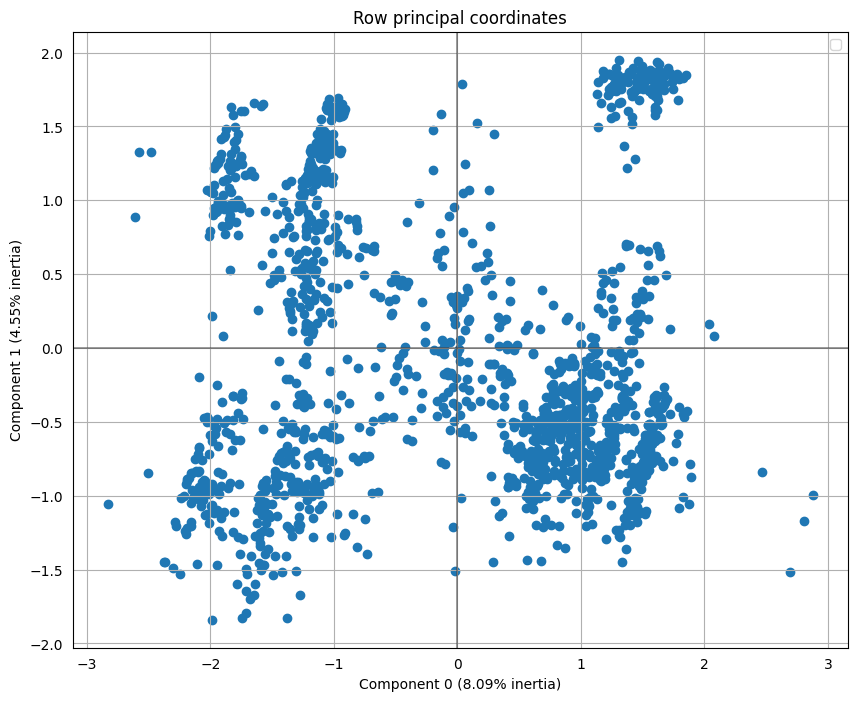

In [9]:
# see the pure plot without spliting factor
make_famd_plot(X, target=True)

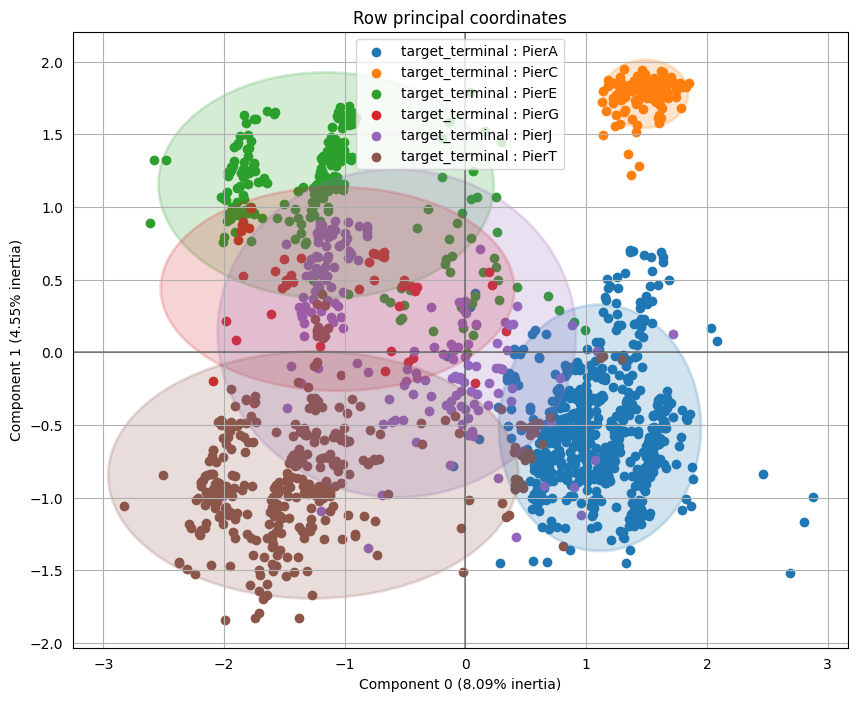

In [10]:
# see the plot with terget_terminal as the spliting factor
make_famd_plot(X, column_name = 'target_terminal')

# ax.get_figure().savefig('images/famd_dwell_time_clustering.svg')

When selecting target_terminal as the splitting factor, we can see overlaps on several ovals, which means data are not well seperated by the target_terminal except the Pier A (orange data points).

Let's split the bined dwell time on the same space and see if it separates well.

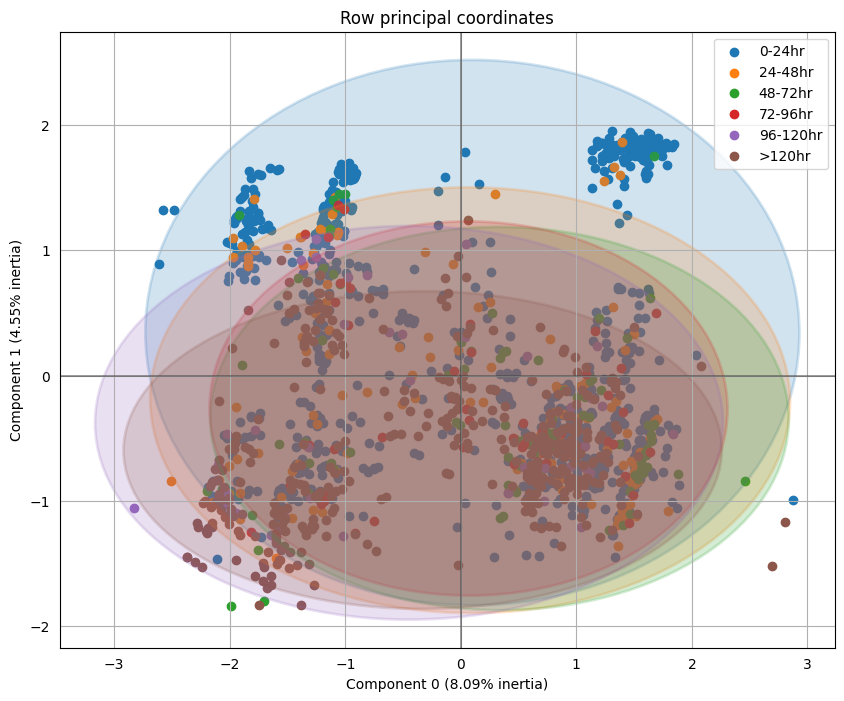

In [11]:
make_famd_plot(X, target=True, target_label=y)

Notice all the colored ovals strongly overlaped. Good separation would be if the ovals really didn't overlap each other much. Therefore, the bined dwell time are not well sperated here. 

In [12]:
# see the explained inertia
print(famd.explained_inertia_)
famd.explained_inertia_.sum()

[0.08092622 0.04548937]


0.12641558592371732

Only 12.5% of the total inertia/variance is explained by the first two components from the FAMD, which is low. The reason for this could due to the increasing total amount of features expended from the raw categorical variables target_terminal and vessel_operator encoded using get_dummies().

Let's explore the correlation between each feature and the components.

In [13]:
# to see the corelated variables in p1 and p2
column_cor = famd.column_correlations(X)
column_cor.sort_values(by=[0,1], ascending = False)

,0,1
target_terminal_PierA,0.595665,-0.596448
vessel_operator_MATSON,0.349071,-0.343209
vessel_operator_PASHA HAWAII HOLDINGS LLC,0.343967,-0.345876
target_terminal_PierC,0.298811,-0.290934
vessel_operator_WAN HAI,0.168303,-0.174091
vessel_operator_ZIM LINES,0.085753,-0.086311
vessel_operator_HAPAG-LLOYD,0.077364,-0.074024
vessel_operator_X-PRESS FEEDERS,0.074715,-0.073358
vessel_operator_LAURITZEN KOSAN,0.072357,-0.074341
vessel_operator_ANL CONTAINER LINE,0.066587,-0.065599


As we can see that Pier A and vessel operator 'MATSON' have moderate positive correlation with the first component, while vessel width, vessel length, and vessel deadweight have high positive correlation with the second component.

From the result, it seems most vessel operators didn't contribute a lot to the components, let's exclude vessel_operator variable here to see how the total explained variance will change.  

In [14]:
X_no_operator = X.drop(['vessel_operator'], axis = 1)

In [15]:
# fit famd model

famd = FAMD(n_components = 2, 
        n_iter = 3, 
        copy = True,
        check_input = True,
        engine = 'auto',
        random_state = 42)
famd.fit(X_no_operator)

# get pcs (global coordinates of each records)
X_no_operator_famd = famd.row_coordinates(X_no_operator)

df['famd2_comp1'] = X_no_operator_famd.iloc[:,0]
df['famd2_comp2'] = X_no_operator_famd.iloc[:,1]

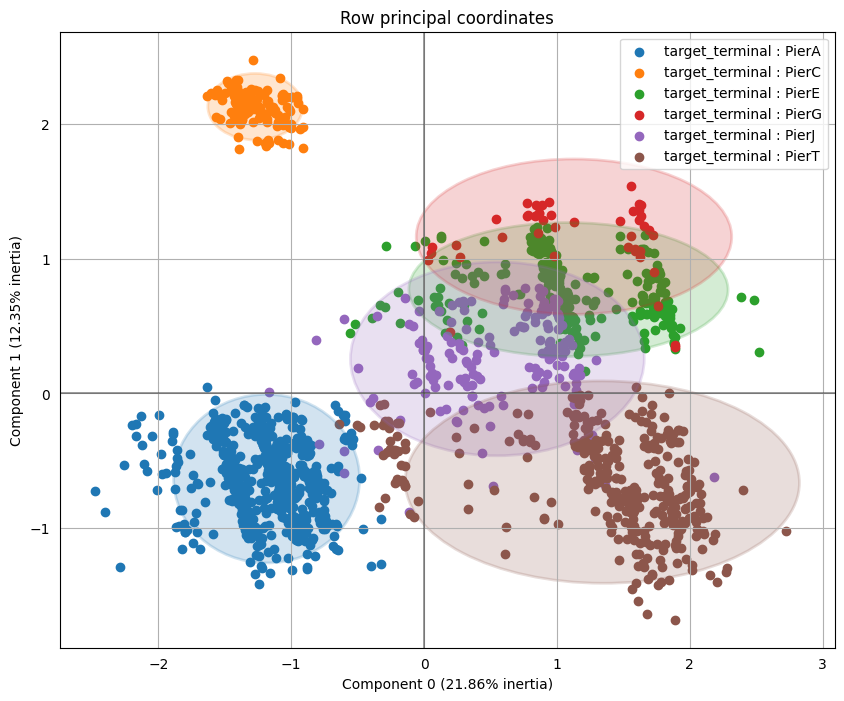

In [16]:
# see the plot with terget_terminal as the spliting factor
make_famd_plot(X_no_operator, column_name = 'target_terminal')

In [17]:
# see the explained inertia
print(famd.explained_inertia_)
famd.explained_inertia_.sum()

[0.21863276 0.12349694]


0.34212970233056594

Findings:

- After excluded the vessor_operator variable, the total explained variance increased from 12.5% to 34%.
- However, the resulting plot in the two components also didn't reflect a dense separation of the data.
- The assumption is that the underlying structure of the data may be non-linear.

Potential improvements:

- Find another method to handle mix type of data and use non-linear techniques such as t-SNE and UMP to explore the global and the local structures of the data. 
- The non-linear dimension reduction FAMD algorithm is great at handling mixed type of variables, and it automically applies a PCA algorithm over the final transformed dataframe. 
- However, we should also apply non-linear dimension reduction techniques because they are more suitable for real world datsets.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b18b33d-3a56-4f49-ad6e-71ecea9f0183' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>